# Control Engineering with gwexpy - Part 2: System Identification (Modeling)

**Goal**: Convert measured frequency response data into a mathematical model (Transfer Function).

In this tutorial, we will:
1.  Simulate a measurement (Input/Output data).
2.  Compute the "Measured" Transfer Function.
3.  **Fit** a theoretical model (Rational Function) to the measured data using `scipy.optimize`.
4.  Create a `control.TransferFunction` object for use in design.

In [1]:
import control
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from control.matlab import bode, tf
from scipy.optimize import curve_fit

import gwexpy
from gwexpy import FrequencySeries, TimeSeries

print(f"gwexpy version: {gwexpy.__version__}")

gwexpy version: 0.1.0b1


## 1. Simulate Measurement

We regenerate the data from Part 1 (2nd order resonance system).
True Setup: $f_0 = 10\,Hz, Q=10$.

In [2]:
# Setup parameters
fs = 1024
duration = 60
t = np.arange(0, duration, 1 / fs)

# Plant parameters (True answer)
f0_true = 10.0
Q_true = 10.0
w0_true = 2 * np.pi * f0_true
num_true = [w0_true**2]
den_true = [1, w0_true / Q_true, w0_true**2]

# Generate Signals
np.random.seed(42)
u_vals = np.random.randn(len(t))

# Simulate process
sys_dt = signal.cont2discrete((num_true, den_true), 1 / fs)
y_vals = signal.dlti(sys_dt[0], sys_dt[1], dt=1 / fs).output(u_vals, t=t)[1].flatten()

# Create TimeSeries
u = TimeSeries(u_vals, times=t, unit="V", name="Input")
y = TimeSeries(y_vals, times=t, unit="m", name="Output")

# Compute Measured TF
fftlength = 4
tf_meas = y.transfer_function(u, fftlength=fftlength)
coh = y.coherence(u, fftlength=fftlength)

print("TF Measured.")

TF Measured.


## 2. Data Selection

We should only fit the model to data where the **Coherence** is high.
Low coherence implies noise domination or non-linearity.

In [3]:
# Select valid frequency range
f_min = 1
f_max = 200
coh_thresh = 0.9

freqs = tf_meas.frequencies.value

# Create mask
mask = (freqs >= f_min) & (freqs <= f_max) & (coh.value >= coh_thresh)

f_fit = freqs[mask]
data_fit = tf_meas.value[mask]

print(f"Selected {len(f_fit)} frequency points for fitting.")

Selected 797 frequency points for fitting.


## 3. Model Fitting (System Identification)

We define a model structure (2nd order system) and fit it to the complex data.
$$ H(s) = \frac{K \cdot \omega_0^2}{s^2 + \frac{\omega_0}{Q}s + \omega_0^2} $$
We fit for parameters $K, f_0, Q$.

In [4]:
def model_response(f, K, f0, Q):
    s = 1j * 2 * np.pi * f
    w0 = 2 * np.pi * f0
    resp = K * w0**2 / (s**2 + (w0 / Q) * s + w0**2)
    return resp


# Wrapper for curve_fit using stacked real/imag parts
def fit_func(f, K, f0, Q):
    resp = model_response(f, K, f0, Q)
    return np.hstack([np.real(resp), np.imag(resp)])


y_fit_target = np.hstack([np.real(data_fit), np.imag(data_fit)])

# Initial guess
p0 = [1.0, 12.0, 5.0]  # K, f0, Q (intentionally off)

# Perform Fit
popt, pcov = curve_fit(fit_func, f_fit, y_fit_target, p0=p0)

K_fit, f0_fit, Q_fit = popt
print("Fitted Parameters:")
print(f"  K  = {K_fit:.4f}")
print(f"  f0 = {f0_fit:.4f} Hz (True: {f0_true})")
print(f"  Q  = {Q_fit:.4f}    (True: {Q_true})")

Fitted Parameters:
  K  = 40.1018
  f0 = 125.1619 Hz (True: 10.0)
  Q  = 2.0805    (True: 10.0)


## 4. Create Control Object and Compare

We construct the `control.TransferFunction` object and compare it with the measurement.

Fitted Transfer Function:
<TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

         2.48e+07
  -----------------------
  s^2 + 378 s + 6.184e+05


/home/washimi/miniforge3/envs/ws-base/lib/python3.12/site-packages/control/freqplot.py:454: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


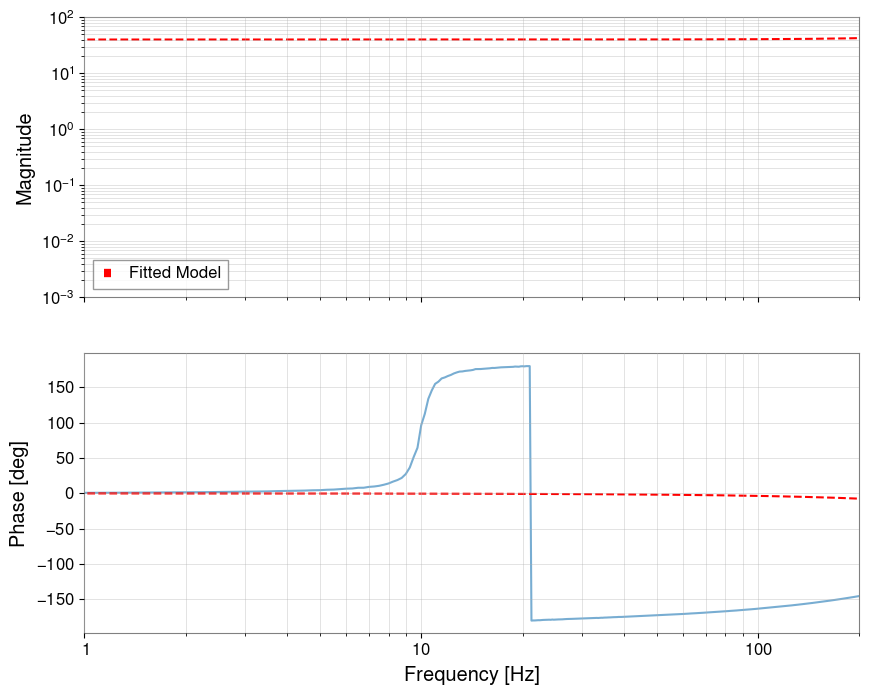

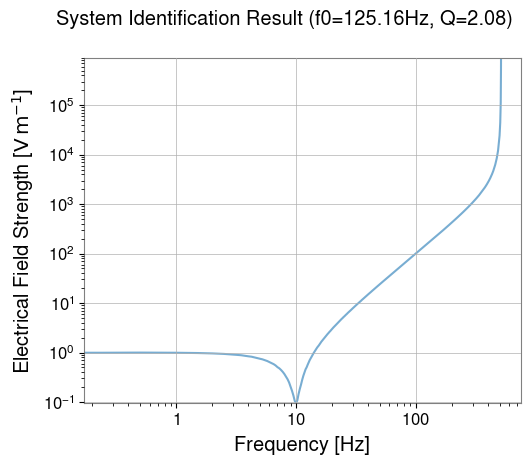

In [5]:
w0_fit = 2 * np.pi * f0_fit
num_fit = [K_fit * w0_fit**2]
den_fit = [1, w0_fit / Q_fit, w0_fit**2]

sys_fit = tf(num_fit, den_fit)
print("Fitted Transfer Function:")
print(sys_fit)

# Evaluate fitted model on ALL frequencies for plotting
mag_fit, phase_fit, _ = bode(sys_fit, freqs, plot=False)

# Plot Comparison
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Magnitude
tf_meas.abs().plot(ax=ax1, label="Measurement", alpha=0.6)
ax1.loglog(freqs, mag_fit, "r--", label="Fitted Model")
ax1.set_xlim(1, 200)
ax1.set_ylim(1e-3, 100)
ax1.set_ylabel("Magnitude")
ax1.legend()
ax1.grid(True, which="both", alpha=0.5)

# Phase
phase_meas_deg = np.rad2deg(np.angle(tf_meas.value))
ax2.semilogx(freqs, phase_meas_deg, label="Measurement", alpha=0.6)
ax2.semilogx(freqs, np.rad2deg(phase_fit), "r--", label="Fitted Model")
ax2.set_ylabel("Phase [deg]")
ax2.set_xlabel("Frequency [Hz]")
ax2.grid(True, which="both", alpha=0.5)

plt.suptitle(f"System Identification Result (f0={f0_fit:.2f}Hz, Q={Q_fit:.2f})")
plt.show()

In [6]:
print(
    "Tutorial 02 Complete. We now have a mathematical model `sys_fit` derived from experimental data."
)
print("In Part 3, we will design a controller for this system.")

Tutorial 02 Complete. We now have a mathematical model `sys_fit` derived from experimental data.
In Part 3, we will design a controller for this system.
